In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [25]:
# =================================================================
# 1. INISIALISASI 
# =================================================================
# Mendefinisikan perangkat secara paksa ke CPU
device = torch.device("cpu") 
print(f"Sistem menjalankan model pada: {device}")

# Path Dataset (Ganti jika folder Anda berbeda)
train_path = r"C:\Users\asus\Downloads\training_FIX"
test_path = r"C:\Users\asus\Downloads\testing_FIX"

# Deteksi jumlah kelas (Batik) secara otomatis
temp_ds = datasets.ImageFolder(root=train_path)
num_classes = len(temp_ds.classes)
print(f"Terdeteksi {num_classes} jenis batik: {temp_ds.classes}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Sistem menjalankan model pada: cpu
Terdeteksi 18 jenis batik: ['Bali', 'Betawi', 'Cenderawasih', 'Dayak', 'Geblek Renteng', 'Ikat Celup', 'Insang', 'Kawung', 'Lasem', 'Mega mendung', 'Pala', 'Parang', 'Poleng', 'Sekar Jagad', 'Sidoluhur', 'Tambal', 'Truntum', 'Tumpal']


In [26]:
# =================================================================
# 2. PREPROCESSING & DATA LOADER
# =================================================================
input_size = 224
batch_size = 16 # Batch size diturunkan ke 16 agar CPU lebih ringan

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BatikDatasetWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

# Merging & Stratified Splitting (70% Train, 15% Val, 15% Test)
train_ds_raw = datasets.ImageFolder(root=train_path)
test_ds_raw = datasets.ImageFolder(root=test_path)
full_dataset = ConcatDataset([train_ds_raw, test_ds_raw])
full_targets = np.array(train_ds_raw.targets + test_ds_raw.targets)

sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_val_idx, test_idx = next(sss_test.split(np.zeros(len(full_targets)), full_targets))

val_ratio_relative = 0.15 / 0.85
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio_relative, random_state=42)
train_idx, val_idx = next(sss_val.split(np.zeros(len(train_val_idx)), full_targets[train_val_idx]))

dataloaders = {
    'train': DataLoader(BatikDatasetWrapper(Subset(full_dataset, train_val_idx[train_idx]), train_transform), batch_size=batch_size, shuffle=True),
    'val': DataLoader(BatikDatasetWrapper(Subset(full_dataset, train_val_idx[val_idx]), val_test_transform), batch_size=batch_size, shuffle=False),
    'test': DataLoader(BatikDatasetWrapper(Subset(full_dataset, test_idx), val_test_transform), batch_size=batch_size, shuffle=False)
}

In [27]:
# =================================================================
# 3. MEMBANGUN MODEL (VGG19 & EfficientNetV2)
# =================================================================

def build_vgg19_optimized(num_classes):
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    for param in model.features.parameters(): param.requires_grad = False
    # Unfreeze block terakhir untuk fine-tuning
    for param in model.features[28:].parameters(): param.requires_grad = True
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model.classifier = nn.Sequential(
        nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model.to(device)

def build_efficientnetv2_optimized(num_classes):
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
    for param in model.features.parameters(): param.requires_grad = False
    for param in model.features[-2:].parameters(): param.requires_grad = True
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model.to(device)

In [40]:
# =================================================================
# 4. FUNGSI TRAINING & EVALUASI
# =================================================================
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Menghilangkan pesan merah PIL

def evaluate_metrics(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss, criterion = 0, nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    return (accuracy_score(all_labels, all_preds), 
            precision_score(all_labels, all_preds, average='macro', zero_division=0),
            recall_score(all_labels, all_preds, average='macro', zero_division=0),
            f1_score(all_labels, all_preds, average='macro', zero_division=0),
            total_loss / len(dataloader.dataset))

def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, patience=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, patience_counter = 0.0, 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward(); optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_train_acc = running_corrects.double() / len(dataloaders['train'].dataset)
        val_acc, _, _, _, epoch_val_loss = evaluate_metrics(model, dataloaders['val'], device)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(val_acc)
        
        # Log lengkap dengan Val Loss agar bisa dibandingkan overfitting-nya
        print(f'Epoch {epoch+1}: Train Loss {epoch_train_loss:.4f} Acc {epoch_train_acc:.4f} | '
              f'Val Loss {epoch_val_loss:.4f} Acc {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience: break

    model.load_state_dict(best_model_wts)
    return model, history, time.time() - since

def plot_history_jurnal(history, title):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.figure(figsize=(12, 5))
    # Accuracy Plot (Sesuai Gambar 4 Jurnal)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-o', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy per Epoch')
    plt.legend(); plt.grid(True)
    # Loss Plot (Sesuai Gambar 5 Jurnal)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title(f'{title} - Loss per Epoch')
    plt.legend(); plt.grid(True)
    plt.show()

In [41]:
# =================================================================
# 5. EKSEKUSI PERBANDINGAN 
# =================================================================

results = {}
all_histories = {} 

for name, builder in [("VGG19", build_vgg19_optimized), ("EfficientNetV2", build_efficientnetv2_optimized)]:
    print(f"\n--- Memulai Pelatihan {name} ---")
    model = builder(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    best_model, hist, t_time = train_model(model, dataloaders, nn.CrossEntropyLoss(), optimizer)
    all_histories[name] = hist 
    
    # Evaluasi Test Set
    acc, prec, rec, f1, _ = evaluate_metrics(best_model, dataloaders['test'], device)
    results[name] = {'Acc': acc, 'Prec': prec, 'Rec': rec, 'F1': f1, 'Time': t_time}

# Tabel Ringkasan Akhir
print("\n" + "="*70)
print(f"{'ARSITEKTUR MODEL':<20} | {'ACC':<6} | {'PREC':<6} | {'REC':<6} | {'F1':<6} | {'WAKTU (s)':<10}")
print("-" * 70)
for m, r in results.items():
    print(f"{m:<20} | {r['Acc']:.4f} | {r['Prec']:.4f} | {r['Rec']:.4f} | {r['F1']:.4f} | {r['Time']:.2f}")


--- Memulai Pelatihan VGG19 ---
Epoch 1: Train Loss 1.7649 Acc 0.4866 | Val Loss 1.0133 Acc 0.7138
Epoch 2: Train Loss 0.9638 Acc 0.7246 | Val Loss 0.8363 Acc 0.7505
Epoch 3: Train Loss 0.7223 Acc 0.7825 | Val Loss 0.8366 Acc 0.7651
Epoch 4: Train Loss 0.5770 Acc 0.8348 | Val Loss 0.7775 Acc 0.8073
Epoch 5: Train Loss 0.5018 Acc 0.8541 | Val Loss 0.7384 Acc 0.7872
Epoch 6: Train Loss 0.4195 Acc 0.8773 | Val Loss 0.8298 Acc 0.7908
Epoch 7: Train Loss 0.3408 Acc 0.8938 | Val Loss 0.8407 Acc 0.7927

--- Memulai Pelatihan EfficientNetV2 ---
Epoch 1: Train Loss 1.7309 Acc 0.5464 | Val Loss 0.9580 Acc 0.7541
Epoch 2: Train Loss 0.7610 Acc 0.7943 | Val Loss 0.5754 Acc 0.8294
Epoch 3: Train Loss 0.4932 Acc 0.8647 | Val Loss 0.5086 Acc 0.8459
Epoch 4: Train Loss 0.3252 Acc 0.9079 | Val Loss 0.4472 Acc 0.8734
Epoch 5: Train Loss 0.2514 Acc 0.9256 | Val Loss 0.4793 Acc 0.8624
Epoch 6: Train Loss 0.1985 Acc 0.9441 | Val Loss 0.4498 Acc 0.8642
Epoch 7: Train Loss 0.1833 Acc 0.9512 | Val Loss 0.481

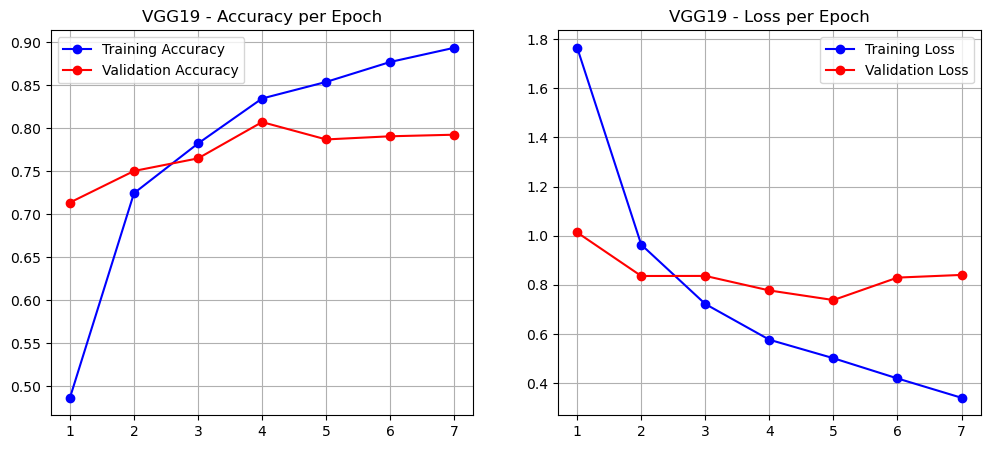

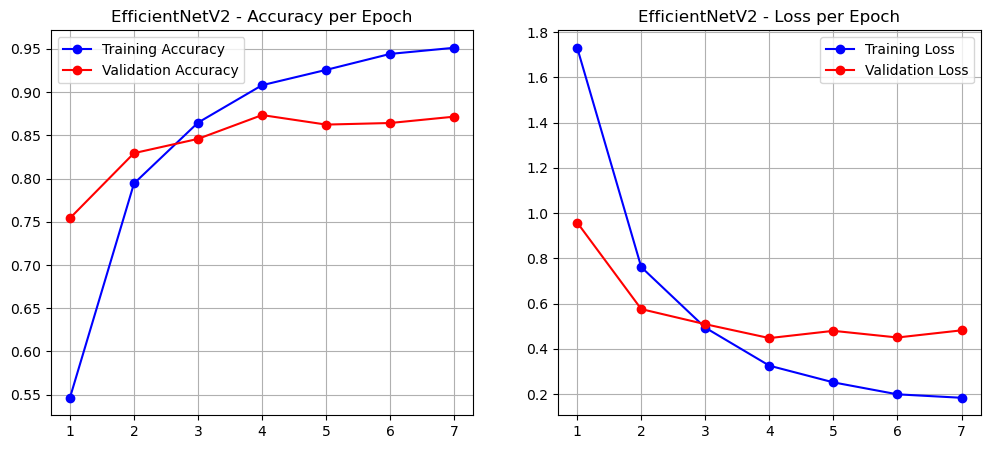

In [42]:
# =================================================================
# 6. PLOT
# =================================================================
plot_history_jurnal(all_histories["VGG19"], "VGG19")
plot_history_jurnal(all_histories["EfficientNetV2"], "EfficientNetV2")